In [1]:
from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A
from itertools import chain
import textdistance
import pandas as pd
import textwrap
import matplotlib.pyplot as plt
import random

If we are going to include 'orchard' in the soil env_local_scale enumeration, we probably shouldn't include 'orchard soil' in the soil env_medium enumeration. NMDC should provide clear guidance on which slot should capture the knowledge that the sample is from an orchard.

Try to discover cases like this, in which a soil has a relationship with a relevant class, and there is strong string similarity between the soil and relevant class labels

In [2]:
adapter_string = "sqlite:obo:envo"

In [3]:
target_labels = ["soil"]

In [4]:
output_file = "discover_excludable_soils.tsv"

Not all relationships between an ABP and a soil are grounds for exclusion. 'has quality', 'participates in process' etc aren't good relationships for driving these exclusions.

In [5]:
reasonable_relations = [
    'adjacent to',
    'composed primarily of',
    'has part',
    'located in',
    'part of',
]


In [6]:
MAT_ENT = "ENVO:00010483"

In [7]:
ENV_MAT = "ENVO:00010483"

In [8]:
BIOME = "ENVO:00000428"

In [9]:
SOIL = 'ENVO:00001998'

In [10]:
adapter = get_adapter(adapter_string)

In [11]:
env_materials = set(adapter.descendants(ENV_MAT, predicates=[IS_A]))

In [12]:
mat_ents = set(adapter.descendants(MAT_ENT, predicates=[IS_A]))

In [13]:
biomes = set(adapter.descendants(BIOME, predicates=[IS_A]))

Astronomical body parts are preferred for env_local_scale, but we'll be a little more inclusive here

In [14]:
relevant_classes = mat_ents - biomes - env_materials

In [15]:
soils = set(adapter.descendants(SOIL, predicates=[IS_A]))

We aren't interested in relationships with 'soil' per se

In [16]:
differentiated_targets = soils.copy()

differentiated_targets.remove(SOIL)

Find relationships between soils and anything, in either oreientation

In [17]:
up_rels = adapter.relationships(soils)

In [18]:
down_rels = adapter.relationships(objects=soils)

In [19]:
rels_gen = chain(up_rels, down_rels)

Turn the soil relationships into a list of dicts, and then a dataframe

In [20]:
rels_list = []

In [21]:
for rel in rels_gen:
    s, p, o = rel
    p_lab_or_id = adapter.label(p) if adapter.label(p) is not None else p
    inner_dict = {
        "s": s,
        "s_is_soil": s in differentiated_targets,
        "s_is_reasonable_other": s in relevant_classes,
        "slab": adapter.label(s),
        "p": p,
        "plab": adapter.label(p),
        "p_lab_or_id": p_lab_or_id,
        'relation_is_reasonable': p_lab_or_id in reasonable_relations,
        "o": o,
        "o_is_soil": o in differentiated_targets,
        "o_is_reasonable_other": o in relevant_classes,
        "olab": adapter.label(o),
        "slab_olab_cosine": textdistance.cosine(adapter.label(s), adapter.label(o))
    }
    if inner_dict['s_is_soil'] and not inner_dict['o_is_soil']:
        inner_dict['sole_soil'] = inner_dict['slab']
    if inner_dict['o_is_soil'] and not inner_dict['s_is_soil']:
        inner_dict['sole_soil'] = inner_dict['olab']

    if inner_dict['s_is_reasonable_other'] and not inner_dict['o_is_reasonable_other']:
        inner_dict['sole_reasonable_other'] = inner_dict['slab']
    if inner_dict['o_is_reasonable_other'] and not inner_dict['s_is_reasonable_other']:
        inner_dict['sole_reasonable_other'] = inner_dict['olab']

    rels_list.append(inner_dict)

In [22]:
rels_frame = pd.DataFrame(rels_list)

Save the unfiltered dataframe of relationships to a file. This file may require manual curation before it is suitable for limiting the soil subclasses that can be excluded from the env_medium slot. Curations could be captured in the 'override' column of `discover_excludable_soils_curated.tsv`

For example,EnvO says that 'mountain forest soil' is part of a 'mountain' and those two labels have a cosine string similarity of 0.632, but we know that 'mountain forest soil' doesn't come from just any mountain, so it shouldn't be excluded from the env_medium slot. In this case, set `override` to 'keep soil'

On the other hand, we will take it for granted that 'farm soil' is part of a farm, even though EnvO doesn't make that assertion as of http://purl.obolibrary.org/obo/envo/releases/2024-07-01/envo.owl

So we make a new row in the curated TSV with farm and 'farm soil' and set `override` to 'exclude soil'. We do the same for greenhouse and 'greenhouse soil'. We also did the same for volcano and 'volcanic soil' but volcanic soil might actually be found at some distance from a volcano, so that should be reconsidered.


- 'allotment garden soil' has a relationship with 'allotment garden'
- 'paddy field soil' has a relationship with 'paddy field'
- 'rubber plantation soil' has a relationship with 'rubber plantation'

but 'allotment garden' etc. are more specific than the kinds of classes we usually include in an env_local_scale enumeration, so those soils may be included in the env_medium enumeration.

- 'alluvial paddy field soil'
- 'beech forest soil'
- 'bluegrass field soil'
- 'eucalyptus forest soil'
- 'jungle soil'
- 'spruce forest soil'
- 'vegetable garden soil'

may also seem like the kinds of soil classes that could be excluded from the env_medium slot, but there are no 'alluvial paddy field' etc. classes in EnvO. We could add them, but they are also more specific than the typical env_local_scale classes.

In [23]:
rels_frame.to_csv(output_file, sep="\t", index=False)

Now filter the dataframe and make a visualizastion

In [24]:
reasonable_frame = rels_frame[rels_frame['relation_is_reasonable']]
# filter out rows with null/NA values
reasonable_frame = reasonable_frame.dropna()

In [25]:
reasonable_frame

,s,s_is_soil,s_is_reasonable_other,slab,p,plab,p_lab_or_id,relation_is_reasonable,o,o_is_soil,o_is_reasonable_other,olab,slab_olab_cosine,sole_soil
11,ENVO:00002236,True,False,cryosol,BFO:0000050,part of,part of,True,ENVO:00000134,False,False,permafrost,0.358569,cryosol
32,ENVO:00002261,True,False,forest soil,RO:0001025,located in,located in,True,ENVO:00000111,False,False,forested area,0.585369,forest soil
34,ENVO:00002262,True,False,clay soil,RO:0002473,composed primarily of,composed primarily of,True,ENVO:00002982,False,False,clay,0.666667,clay soil
37,ENVO:00002275,True,False,technosol,BFO:0000050,part of,part of,True,ENVO:01000983,False,False,technosphere,0.673575,technosol
63,ENVO:00005740,True,False,paddy field soil,BFO:0000050,part of,part of,True,ENVO:00000297,False,False,paddy field,0.829156,paddy field soil
68,ENVO:00005743,True,False,roadside soil,RO:0001025,located in,located in,True,ENVO:01000447,False,False,roadside,0.784465,roadside soil
70,ENVO:00005744,True,False,allotment garden soil,BFO:0000050,part of,part of,True,ENVO:00005745,False,False,allotment garden,0.872872,allotment garden soil
77,ENVO:00005750,True,False,grassland soil,RO:0001025,located in,located in,True,ENVO:00000106,False,False,grassland area,0.714286,grassland soil
84,ENVO:00005755,True,False,field soil,BFO:0000050,part of,part of,True,ENVO:00000114,False,False,agricultural field,0.596285,field soil
88,ENVO:00005758,True,False,alluvial swamp soil,BFO:0000050,part of,part of,True,ENVO:00000233,False,False,swamp ecosystem,0.473879,alluvial swamp soil


Convert the filtered dataframe back to a list of dicts, for more straightforward iterating

In [26]:
reasonable_lod = reasonable_frame.to_dict(orient='records')

Create plotting groups based on relationship predicates, preferably by label. (By relationship CURIe if there is no label.)

In [27]:
# Extract unique groups from 'p_lab_or_id' and map each one to an x-axis position
groups = {item['p_lab_or_id'] for item in reasonable_lod}
group_positions = {group: idx + 1 for idx, group in
                   enumerate(groups)}  # Assign positions for each unique 'p_lab_or_id' group

Helper function to wrap labels

In [28]:
def wrap_label(label, width=15):
    return "\n".join(textwrap.wrap(label, width))

Define a set of colors, for making it easier to distinguish close or overlapping text on the plot

In [29]:
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#FF8F33', '#33FFF2', '#E1FF33']

In [30]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 15)  # Width, Height in inches
plt.rcParams["figure.dpi"] = 100  # Increase resolution for clarity

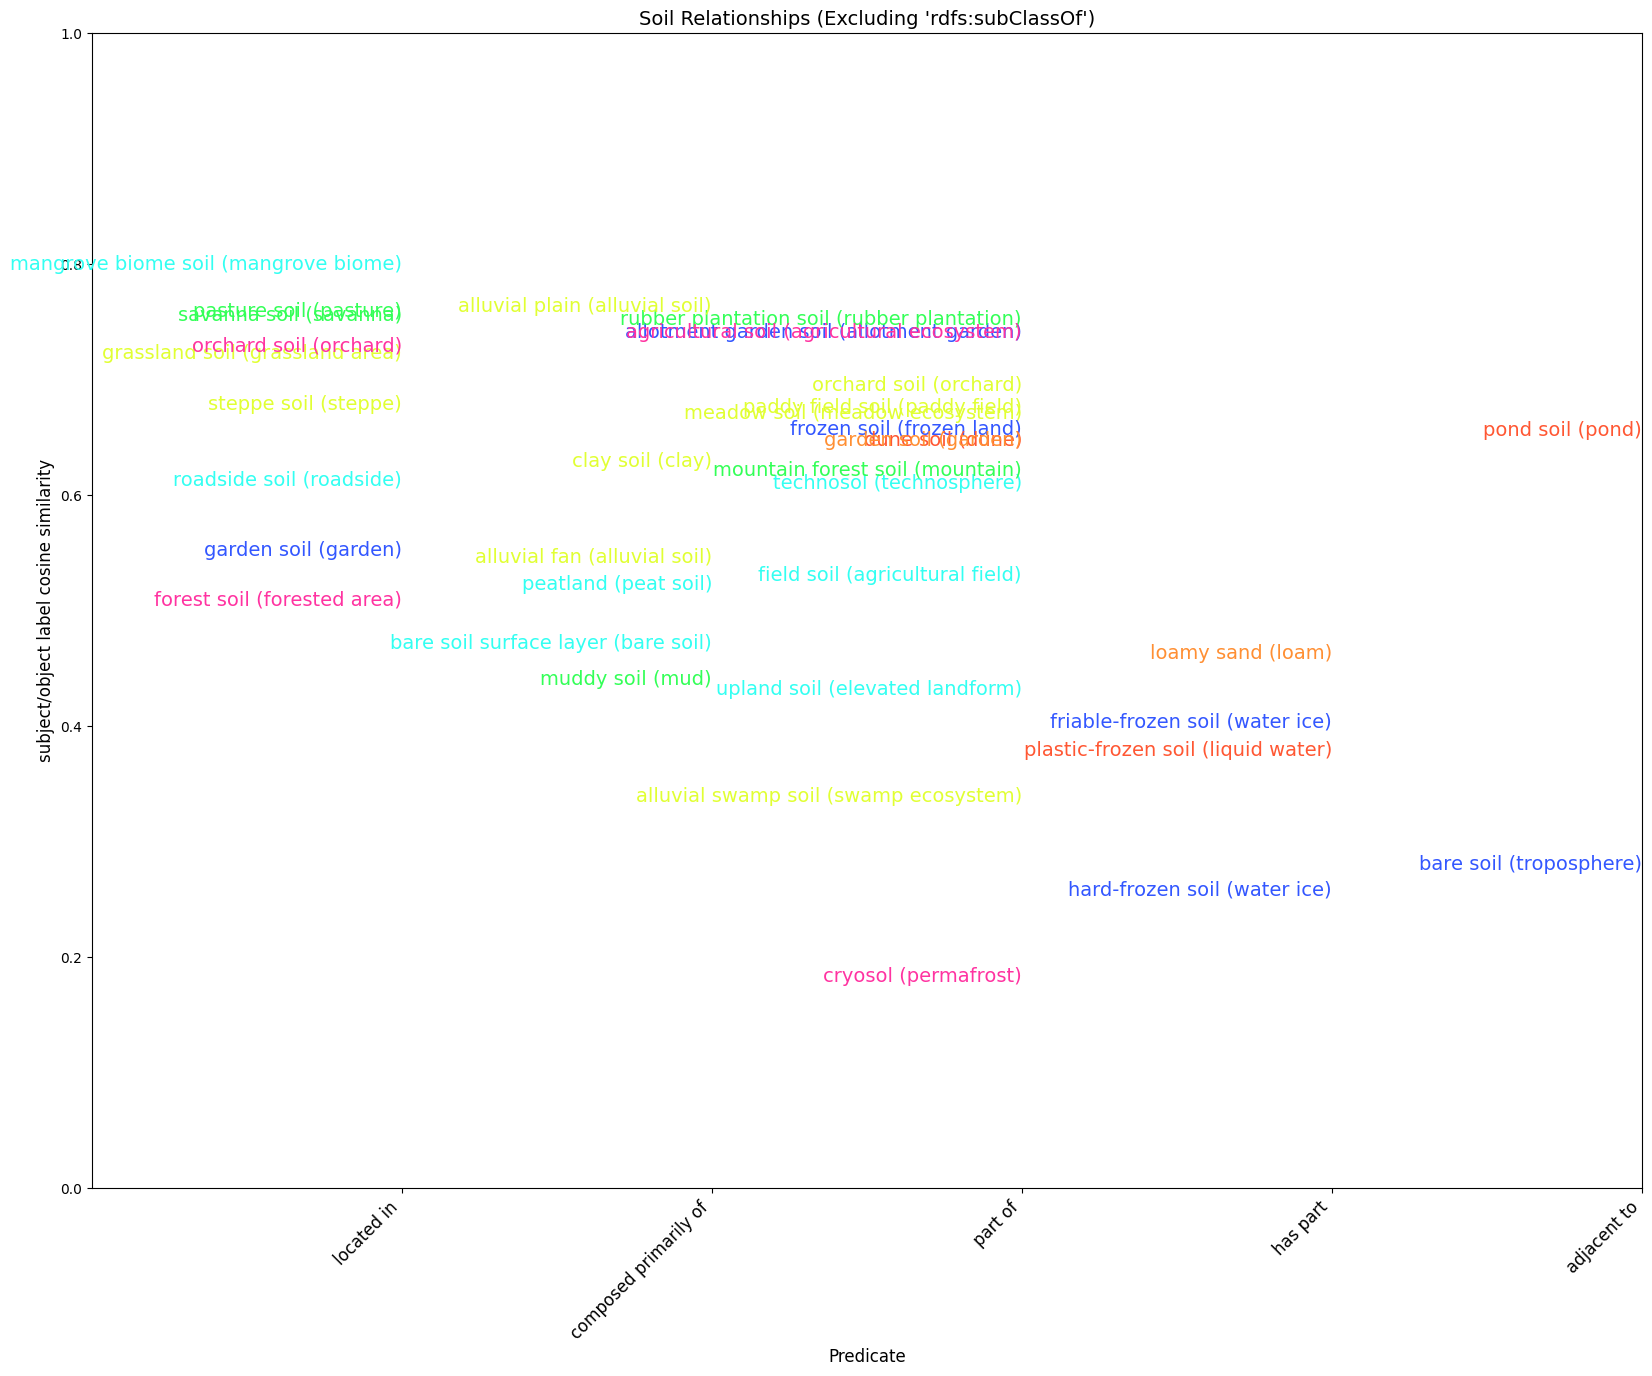

In [31]:
# Plot each label with more random jitter and random color
for item in reasonable_lod:
    x = group_positions[item['p_lab_or_id']]
    y = item['slab_olab_cosine']
    label = f"{item['slab']} ({item['olab']})"
    wrapped_label = wrap_label(label, width=50)

    # Add increased random jitter to the label position
    y_jitter = random.uniform(-0.2, 0.0)  # Larger random jitter in y-axis

    # Select a random color for the label
    color = random.choice(colors)  # Alternatively, use color = (random.random(), random.random(), random.random())

    # # Plot the label with random color
    plt.text(x, y + y_jitter , wrapped_label, ha='right', va='bottom', fontsize=14, color=color)

# Increase x-tick label size and rotate
plt.xticks(ticks=list(group_positions.values()), labels=list(group_positions.keys()), rotation=45, ha='right',
           fontsize=12)

# Configure other plot aesthetics
plt.xlabel("Predicate", fontsize=12)
plt.ylabel("subject/object label cosine similarity", fontsize=12)
plt.title("Soil Relationships (Excluding 'rdfs:subClassOf')", fontsize=14)


plt.show()